### Convolutional Neural Networks

import numpy as np
import tensorflow as tf 



In [ ]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import categorical_crossentropy 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import itertools 
import os
import shutil 
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Next, apply a system-level safety measure for GPU-enabled devices. 
**Why?** 
- safer training 
- multiple processes can share GPU 
- fewer random crashes 

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


In [ ]:
# a list of resources (CPUs/GPUs) detected
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

**Data Preparation**

The images are included in the data/cats and data/dogs directories, already split. But we'll make sure we have these directories: 
- data/train/ 
- data/valid/
- data/test/ 

for both cats and dogs 

In [12]:
# organize data into train, valid and test dirs 

# os.getcwd() # 'C:\\Users\\username'
# os.chdir('Documents/Deep-Learning-Chronicles/image_classification_CNN/data')
# os.listdir()

if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for c in random.sample(glob.glob('Cat/*'), 500): 
        shutil.move(c, 'train/cat')
    for c in random.sample(glob.glob('Dog/*'), 500): 
        shutil.move(c, 'train/dog')
    for c in random.sample(glob.glob('Cat/*'), 100): 
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob('Dog/*'), 100): 
        shutil.move(c, 'valid/dog')
    for c in random.sample(glob.glob('Cat/*'), 50): 
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob('Dog/*'), 50): 
        shutil.move(c, 'test/dog')

change directory to root of the project

In [15]:
# os.chdir('../')
os.listdir()

['data', 'image_classification.ipynb']

In [16]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

Putting the data into a format that the model expects.  
In this case, we put it into a format of a keras generator
(**tensorflow.keras.preprocessing.image.ImageDataGenerator**)

In [17]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Verifying if that is the case

In [21]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes
# train_batches.num_classes

In [22]:
imgs, labels = next(train_batches)

In [27]:
# This function will plot images in the form of a grid with 1 row and 10 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes): 
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-99.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..126.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

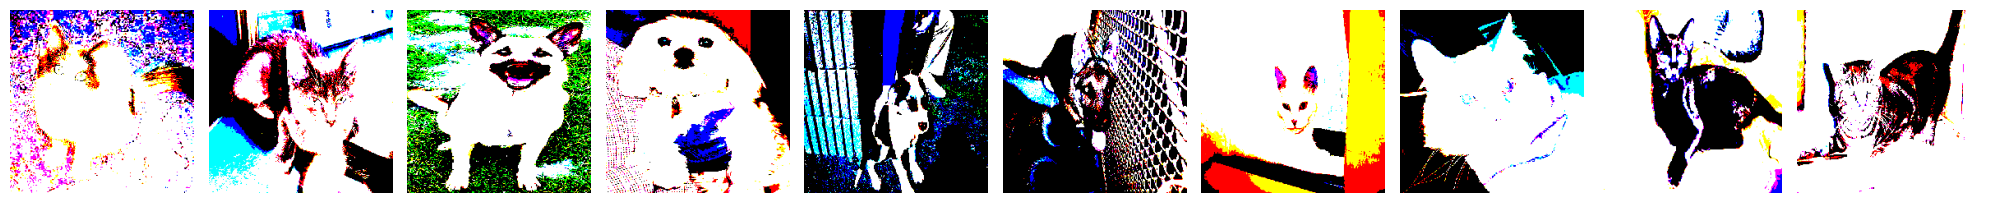

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [28]:
plotImages(imgs)
print(labels)

So far we have: 
- obtained our image data 
- organized it on disk
- processed it accordingly for our Convolutional Neural Network

### **Building and Training the CNN**
(with Tensorflow's Keras API)

In [29]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2,2), strides=2), 
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2), 
    Flatten(),
    Dense(units=2, activation='softmax'),
])

C:\Users\ianwr\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │         401,410 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


C:\Users\ianwr\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


100/100 - 34s - 342ms/step - accuracy: 0.5330 - loss: 18.8268 - val_accuracy: 0.6200 - val_loss: 7.5915
Epoch 2/10
100/100 - 24s - 239ms/step - accuracy: 0.7440 - loss: 3.1796 - val_accuracy: 0.6800 - val_loss: 2.7003
Epoch 3/10
100/100 - 24s - 240ms/step - accuracy: 0.8990 - loss: 0.4794 - val_accuracy: 0.6450 - val_loss: 2.1913
Epoch 4/10
100/100 - 24s - 239ms/step - accuracy: 0.9610 - loss: 0.1336 - val_accuracy: 0.6800 - val_loss: 2.0877
Epoch 5/10
100/100 - 24s - 244ms/step - accuracy: 0.9870 - loss: 0.0354 - val_accuracy: 0.6750 - val_loss: 2.1810
Epoch 6/10
100/100 - 25s - 247ms/step - accuracy: 0.9970 - loss: 0.0110 - val_accuracy: 0.6650 - val_loss: 2.0528
Epoch 7/10
100/100 - 24s - 242ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6800 - val_loss: 2.0241
Epoch 8/10
100/100 - 24s - 242ms/step - accuracy: 1.0000 - loss: 7.7308e-04 - val_accuracy: 0.6850 - val_loss: 2.0329
Epoch 9/10
100/100 - 25s - 249ms/step - accuracy: 1.0000 - loss: 6.2516e-04 - val_accuracy: 0.

### **Predict**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-108.779..71.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-94.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..88.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-105.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to

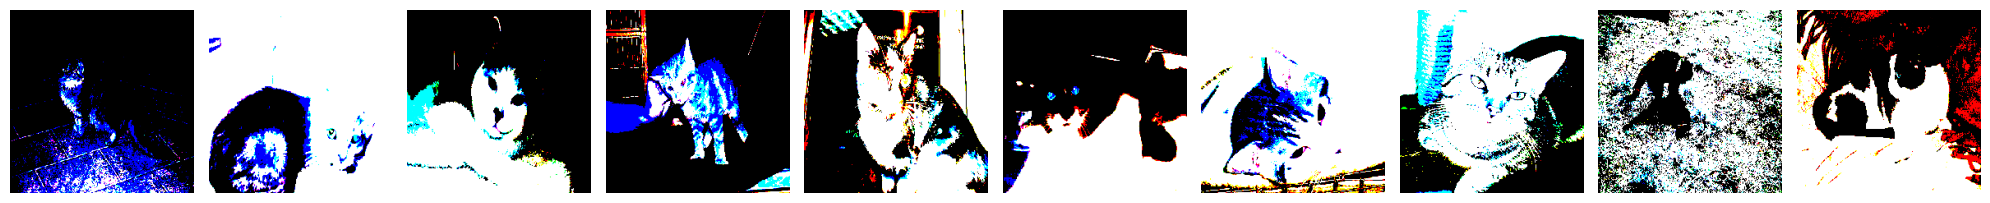

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [34]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [35]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [38]:
predictions = model.predict(x=test_batches, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [41]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [42]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))